In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
import tensorflow.lite as tflite

In [ ]:
# Define paths to the dataset
DATASET_PATH = '/content/drive/MyDrive/ML/gender_dataset/'
TRAIN_MEN_PATH = os.path.join(DATASET_PATH, 'train', 'men')
TRAIN_WOMEN_PATH = os.path.join(DATASET_PATH, 'train', 'women')
TEST_MEN_PATH = os.path.join(DATASET_PATH, 'test', 'men')
TEST_WOMEN_PATH = os.path.join(DATASET_PATH, 'test', 'women')
IMG_SIZE = (96, 96)  # Match Arducam OV2640 output for TinyML
NUM_CLASSES = 2  # Men and Women

In [ ]:
# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Grayscale to save memory
    img = cv2.resize(img, IMG_SIZE)  # Resize to 96x96
    img = img.astype('float32') / 255.0  # Normalize to [0, 1]
    return img

In [ ]:
# Load training dataset
def load_train_dataset():
    images = []
    labels = []

    for img_name in os.listdir(TRAIN_MEN_PATH):
        img_path = os.path.join(TRAIN_MEN_PATH, img_name)
        img = load_and_preprocess_image(img_path)
        images.append(img)
        labels.append(0)  # Label 0 for men

    for img_name in os.listdir(TRAIN_WOMEN_PATH):
        img_path = os.path.join(TRAIN_WOMEN_PATH, img_name)
        img = load_and_preprocess_image(img_path)
        images.append(img)
        labels.append(1)  # Label 1 for women

    images = np.array(images).reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)  # Add channel dimension
    labels = np.array(labels)
    return images, labels


In [ ]:
# Load test dataset
def load_test_dataset():
    images = []
    labels = []

    for img_name in os.listdir(TEST_MEN_PATH):
        img_path = os.path.join(TEST_MEN_PATH, img_name)
        img = load_and_preprocess_image(img_path)
        images.append(img)
        labels.append(0)  # Label 0 for men

    for img_name in os.listdir(TEST_WOMEN_PATH):
        img_path = os.path.join(TEST_WOMEN_PATH, img_name)
        img = load_and_preprocess_image(img_path)
        images.append(img)
        labels.append(1)  # Label 1 for women

    images = np.array(images).reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)  # Add channel dimension
    labels = np.array(labels)
    return images, labels

In [ ]:
# === 3. Define lightweight model Architecture ===
def micro_block(x, filters, strides=1):
    x = layers.Conv2D(filters, 3, strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def build_micronet_m3(input_shape=(96, 96, 1)):  # Changed to 1 channel
    inputs = tf.keras.Input(shape=input_shape)
    x = micro_block(inputs, 8, 2)
    x = micro_block(x, 16, 2)
    x = micro_block(x, 32, 2)
    x = micro_block(x, 64, 2)
    x = micro_block(x, 128, 2)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs, x)

In [ ]:
# Load datasets
X_train, y_train = load_train_dataset()
X_test, y_test = load_test_dataset()

# Convert labels to categorical
#y_train = tf.keras.utils.to_categorical(y_train, NUM_CLASSES) # Removed one-hot encoding
#y_test = tf.keras.utils.to_categorical(y_test, NUM_CLASSES)   # Removed one-hot encoding

#Model trained
model = build_micronet_m3(input_shape=(96, 96, 1))  # Match grayscale input
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Changed loss function
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.4648 - loss: 0.7910 - val_accuracy: 0.5500 - val_loss: 0.6930
Epoch 2/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.6683 - loss: 0.5880 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.7400 - loss: 0.5468 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 4/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.8423 - loss: 0.4263 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 5/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.8774 - loss: 0.3499 - val_accuracy: 0.5000 - val_loss: 0.6946
Epoch 6/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.8804 - loss: 0.3239 - val_accuracy: 0.5000 - val_loss: 0.6945
Epoch 7/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9663 - loss: 0.2094 - val_accuracy: 0.5000 - val_loss: 0.6945
Epoch 8/25
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9873 - loss: 0.1549 - val_accuracy: 0.5125 - val_loss: 0.6

In [ ]:
# Evaluate accuracy on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3711 - loss: 0.8398
Test accuracy: 50.00%


In [ ]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 48, 48, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 48, 48, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_45 (ReLU)                 │ (None, 48, 48, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 24, 24, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 24, 24, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_46 (ReLU)                 │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 12, 12, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 12, 12, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_47 (ReLU)                 │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 6, 6, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 6, 6, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_48 (ReLU)                 │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_49 (ReLU)                 │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,093 (1.13 MB)

 Trainable params: 98,865 (386.19 KB)

 Non-trainable params: 496 (1.94 KB)

 Optimizer params: 197,732 (772.39 KB)

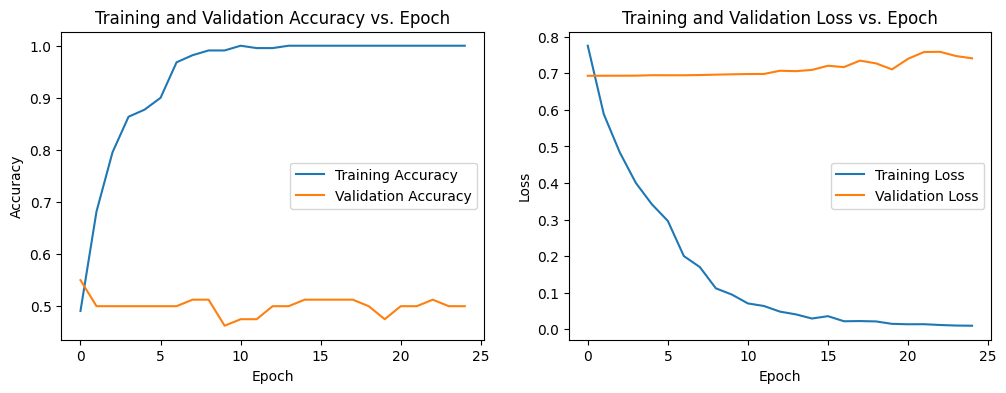

In [ ]:
import matplotlib.pyplot as plt

# Get the history object from the model training
# history = model.history # This line is not needed as history is already available

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Epoch')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Epoch')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


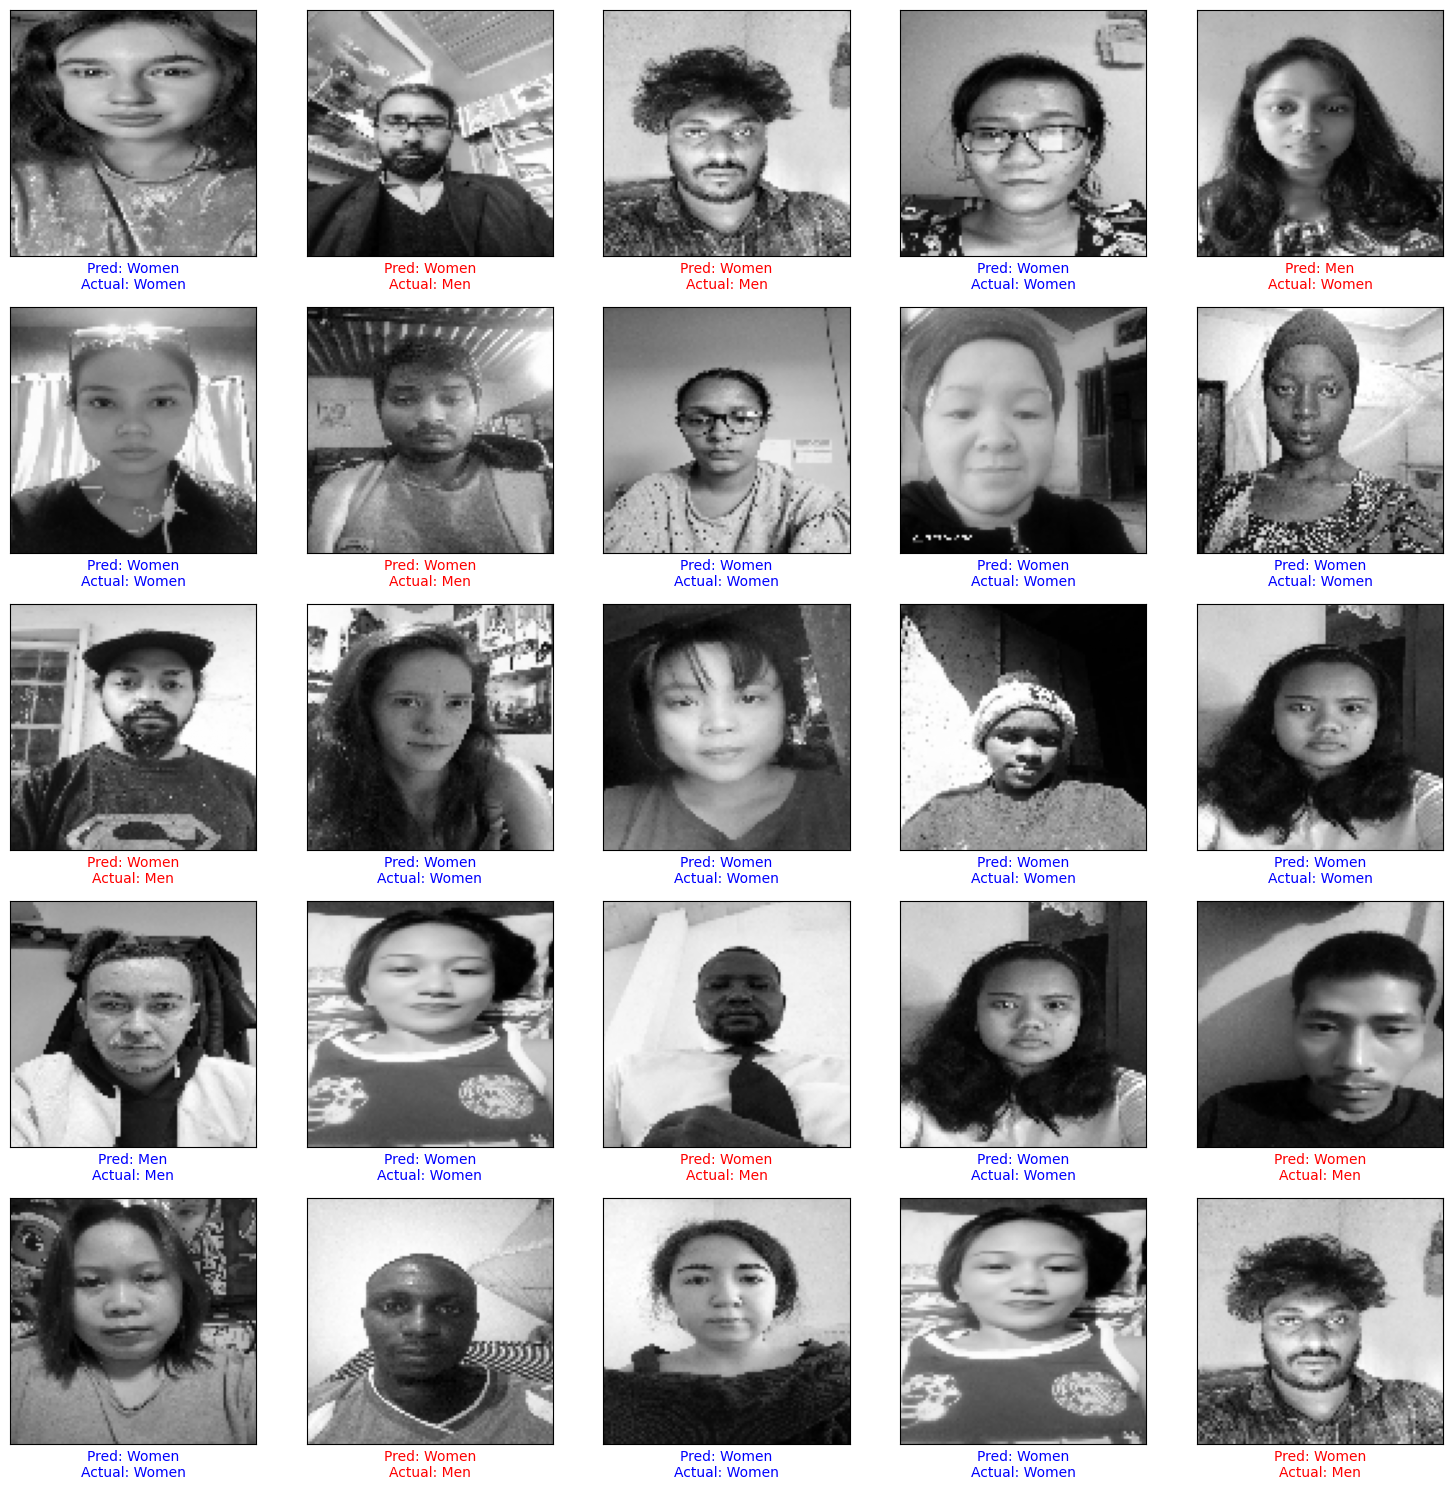

In [ ]:
# Get the test dataset again to iterate through images
test_images, test_labels_original = load_test_dataset() # Load original labels (not one-hot encoded)

class_names = ['Men', 'Women']

# Perform multiple tests on random images and display in columns
num_tests = 25  # You can change this number
num_cols = 5   # Number of columns to display the images
num_rows = (num_tests + num_cols - 1) // num_cols # Calculate number of rows

plt.figure(figsize=(num_cols * 3, num_rows * 3)) # Adjust figure size based on number of images and columns

for i in range(num_tests):
    random_index = np.random.randint(0, len(test_images))

    plt.subplot(num_rows, num_cols, i + 1) # Create subplot for each image
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    img = test_images[random_index]
    # Remove the channel dimension for displaying the grayscale image
    plt.imshow(img.squeeze(), cmap='gray')

    # Get prediction for the current image
    img_for_prediction = np.expand_dims(img, axis=0) # Add batch dimension
    prediction = model.predict(img_for_prediction)

    # For binary classification with sigmoid output, the prediction is a single value
    # We can consider a value > 0.5 as class 1 (Women) and <= 0.5 as class 0 (Men)
    predicted_class_index = 1 if prediction[0][0] > 0.5 else 0

    predicted_class = class_names[predicted_class_index]
    actual_class = class_names[test_labels_original[random_index]]

    color = 'blue' if predicted_class_index == test_labels_original[random_index] else 'red'

    plt.xlabel(f'Pred: {predicted_class}\nActual: {actual_class}', color=color)

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


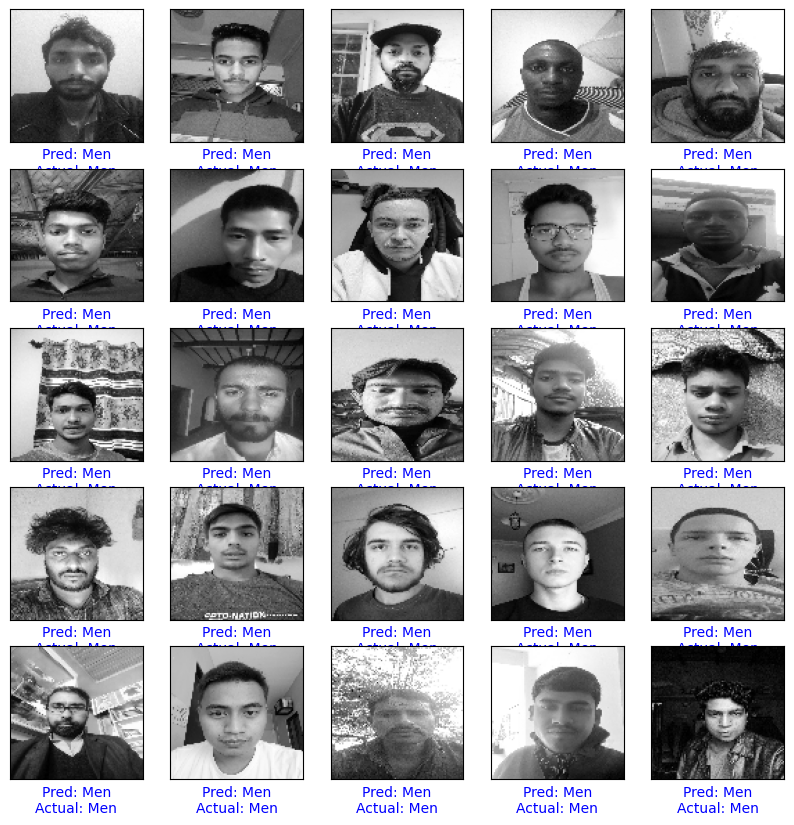

In [ ]:
# Get the test dataset again to iterate through images
test_images, test_labels_original = load_test_dataset() # Load original labels (not one-hot encoded)

class_names = ['Men', 'Women']

plt.figure(figsize=(10, 10))
for i in range(min(25, len(test_images))): # Display up to 25 images
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    img = test_images[i]
    # Remove the channel dimension for displaying the grayscale image
    plt.imshow(img.squeeze(), cmap='gray')

    # Get prediction for the current image
    img_for_prediction = np.expand_dims(img, axis=0) # Add batch dimension
    prediction = model.predict(img_for_prediction)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]
    actual_class = class_names[test_labels_original[i]]

    color = 'blue' if predicted_class_index == test_labels_original[i] else 'red'

    plt.xlabel(f'Pred: {predicted_class}\nActual: {actual_class}', color=color)
plt.show()

In [ ]:
# Save the trained model
model.save('gender_classification_model_12_07.h5')
print("Model saved successfully!")

Model saved successfully!


In [43]:
# Convert the Keras model to a TensorFlow Lite model
converter = tflite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
with open('gender_classification_model_12_07.tflite', 'wb') as f:
    f.write(tflite_model)

print("TensorFlow Lite model saved successfully!")

Saved artifact at '/tmp/tmp_nmoe2n2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name='keras_tensor_166')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134186410890576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134186410887888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134186468554512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134186468551440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134186468552592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134186468552784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134186468547984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134186468540496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134186468550672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134186468548944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134186468553

In [44]:
# Convert the Keras model to a TensorFlow Lite model with full integer quantization
converter = tflite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8  # Or tf.uint8
converter.inference_output_type = tf.int8  # Or tf.uint8

# You need a representative dataset for full integer quantization
def representative_dataset_gen():
    # Assuming X_train is available and contains your training data
    for i in range(X_train.shape[0]):
        yield [X_train[i:i+1]]

converter.representative_dataset = representative_dataset_gen

tflite_model_quantized = converter.convert()

# Save the quantized TensorFlow Lite model
with open('gender_classification_model_quantized_int8_12_07.tflite', 'wb') as f:
    f.write(tflite_model_quantized)

print("Fully quantized (int8) TensorFlow Lite model saved successfully!")

Saved artifact at '/tmp/tmp303azzbc'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name='keras_tensor_166')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134186410890576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134186410887888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134186468554512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134186468551440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134186468552592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134186468552784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134186468547984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134186468540496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134186468550672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134186468548944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134186468553

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Fully quantized (int8) TensorFlow Lite model saved successfully!


In [47]:
# Generate C array for Arduino
def convert_tflite_to_c_array(tflite_path, output_path):
    with open(tflite_path, 'rb') as f:
        model_content = f.read()
    with open(output_path, 'w') as f:
        f.write('#ifndef GENDER_DETECTION_MODEL_H_\n')
        f.write('#define GENDER_DETECTION_MODEL_H_\n\n')
        f.write('static const unsigned char model_data[] = {\n')
        for i, byte in enumerate(model_content):
            f.write(f'0x{byte:02x}')
            if i < len(model_content) - 1:
                f.write(',')
            if (i + 1) % 16 == 0:
                f.write('\n')
        f.write('\n};\n\n')
        f.write(f'static const int model_data_len = {len(model_content)};\n')
        f.write('#endif\n')

convert_tflite_to_c_array('gender_classification_model_quantized_int8_12_07.tflite', 'gender_detection_model_12_07.h')

In [49]:
# Load the TFLite model and allocate tensors.
interpreter = tflite.Interpreter(model_path='gender_classification_model_quantized_int8_12_07.tflite')
interpreter.allocate_tensors()

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Tensor Details:")
for details in input_details:
    print(f"  Name: {details['name']}")
    print(f"  Shape: {details['shape']}")
    print(f"  Data type: {details['dtype']}")
    print(f"  Quantization parameters: {details['quantization_parameters']}")
    print("-" * 20)

print("\nOutput Tensor Details:")
for details in output_details:
    print(f"  Name: {details['name']}")
    print(f"  Shape: {details['shape']}")
    print(f"  Data type: {details['dtype']}")
    print(f"  Quantization parameters: {details['quantization_parameters']}")
    print("-" * 20)

Input Tensor Details:
  Name: serving_default_keras_tensor_166:0
  Shape: [ 1 96 96  1]
  Data type: <class 'numpy.int8'>
  Quantization parameters: {'scales': array([0.00392157], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}
--------------------

Output Tensor Details:
  Name: StatefulPartitionedCall_1:0
  Shape: [1 1]
  Data type: <class 'numpy.int8'>
  Quantization parameters: {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}
--------------------
